<a href="https://colab.research.google.com/github/GarlandZhang/mnist_digit_gan/blob/master/mnist_digit_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
from keras.datasets.mnist import load_data
from keras.layers import Conv2D, LeakyReLU, Dropout, Flatten, Dense, Reshape, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import numpy as np

In [11]:
def build_discriminator(input_shape=(28, 28, 1)):
  model = Sequential([
      Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape),
      LeakyReLU(alpha=0.2),
      Dropout(0.4),
      Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
      LeakyReLU(alpha=0.2),
      Dropout(0.4),
      Flatten(),
      Dense(1, activation='sigmoid')
  ])

  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model

In [12]:
model = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)             

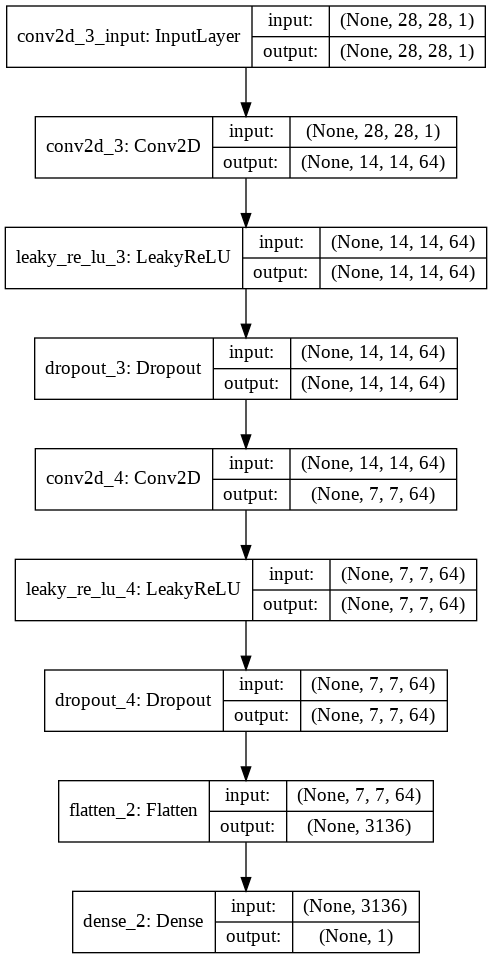

In [15]:
model.summary()
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [74]:
def to_images():
  (train_x, train_y), (test_x, test_y) = load_data()
  return np.expand_dims(train_x, axis=-1).astype('float32') / 255.

In [51]:
def generate_real(dataset, num):
  num_training = dataset.shape[0]
  sample_inds = np.random.randint(0, num_training, num)
  samples = dataset[sample_inds]
  y = np.ones((num, 1))
  return samples, y

In [90]:
def generate_fake(model, latent_dim, num):
  # samples = np.random.uniform(0, 1, (num, 28, 28, 1))
  noise = generate_noise(latent_dim, num)
  samples = model.predict(noise)
  y = np.zeros((num, 1))
  return samples, y

In [86]:
def train_discriminator(model, dataset, generator, latent_dim, batch_size=100, num_iters=100):
  batch_size_each = batch_size // 2
  for i in range(num_iters):
    real_x, real_y = generate_real(dataset, batch_size_each)
    fake_x, fake_y = generate_fake(generator, latent_dim, batch_size_each)

    _, real_acc = model.train_on_batch(real_x, real_y)
    _, fake_acc = model.train_on_batch(fake_x, fake_y)

    print(f'Real acc: {real_acc} vs. Fake acc: {fake_acc}')

    # comb_x = np.append(real_x, fake_x)
    # comb_y = np.append(real_y, fake_y)
    # _, acc = model.train_on_batch(comb_x, comb_y)


In [81]:
def build_generator(input_dim=100):
  low_res_w = 7
  low_res_h = 7
  model = Sequential([
    Dense(128 * low_res_w * low_res_h, input_dim=input_dim),
    LeakyReLU(alpha=0.2),
    Reshape((low_res_h, low_res_w, 128)),
    Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'), # kernel size should be factor of stride size
    LeakyReLU(alpha=0.2),
    Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
    LeakyReLU(alpha=0.2),
    Conv2D(1, (low_res_h, low_res_w), activation='sigmoid', padding='same')
  ])

  # no compile because will be used to combine with discriminator

  return model

In [64]:
def generate_noise(latent_dim, num):
  noise = np.random.uniform(0, 1, (num, latent_dim))
  return noise

In [84]:
def build_gan(generator, discriminator):
  discriminator.trainable = False
  model = Sequential([
    generator,
    discriminator,
  ])

  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [67]:
def train_gan(model, latent_dim, batch_size=100, num_iters=100):
  for i in range(num_iters):
    noise = generate_noise(latent_dim, batch_size)
    y = np.ones((batch_size, 1))
    _, loss = model.train_on_batch(noise, y)
    print(f'Loss: {loss}')

In [87]:
def train(generator, discriminator, gan, dataset, latent_dim, num_epochs=100, batch_size=100):
  batch_per_epoch = dataset.shape[0] // batch_size
  batch_size_each = batch_size // 2

  for e in range(num_epochs):
    for i in range(batch_per_epoch):
      # disciminator.trainable = True
      print('Train discriminator')
      train_discriminator(discriminator, dataset, generator, latent_dim, batch_size=batch_size)
      # discriminator.trainable = False
      print('Train generator')
      train_gan(gan, latent_dim, batch_size=batch_size) # gan loss includes both d_loss and g_loss
      # print(f'Discriminator: {d_loss} vs. Generator: {g_loss}')

    if e % 10 == 0:
      summarize_performance(generator, discriminator, dataset, latent_dim)


In [88]:
def summarize_performance(generator, discriminator, dataset, latent_dim, num_samples=100):
  x_real, y_real = generate_real(dataset, num_samples)
  _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)

  x_fake, y_fake = generate_fake(num_samples)
  _, acc_fake = discriminator.evaluate(x_fake ,y_fake, verbose=0)

  print(f'Real: {acc_real} vs. Fake: {acc_fake}')

In [ ]:
latent_dim=100
discriminator = build_discriminator()
generator = build_generator()
gan = build_gan(generator, discriminator)
dataset = to_images()
train(generator, discriminator, gan, dataset, latent_dim)

Train discriminator


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Real acc: 0.47999998927116394 vs. Fake acc: 0.07999999821186066
Real acc: 0.7200000286102295 vs. Fake acc: 0.3400000035762787
Real acc: 0.6200000047683716 vs. Fake acc: 0.5400000214576721
Real acc: 0.6200000047683716 vs. Fake acc: 0.7599999904632568
Real acc: 0.5400000214576721 vs. Fake acc: 0.9599999785423279
Real acc: 0.5400000214576721 vs. Fake acc: 0.9399999976158142
Real acc: 0.6399999856948853 vs. Fake acc: 0.9800000190734863
Real acc: 0.6000000238418579 vs. Fake acc: 1.0
Real acc: 0.5799999833106995 vs. Fake acc: 1.0
Real acc: 0.7400000095367432 vs. Fake acc: 1.0
Real acc: 0.6399999856948853 vs. Fake acc: 1.0
Real acc: 0.5799999833106995 vs. Fake acc: 1.0
Real acc: 0.5 vs. Fake acc: 1.0
Real acc: 0.6600000262260437 vs. Fake acc: 1.0
Real acc: 0.699999988079071 vs. Fake acc: 1.0
Real acc: 0.7400000095367432 vs. Fake acc: 1.0
Real acc: 0.7599999904632568 vs. Fake acc: 1.0
Real acc: 0.7400000095367432 vs. Fake acc: 1.0
Real acc: 0.8399999737739563 vs. Fake acc: 1.0
Real acc: 0.8199